In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# read in words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
block_size = 3
def build_dataset(words):
    block_size = 3
    X, Y = [] , []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [21]:
def cmp(s ,dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff:{maxdiff}' )

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [28]:
vocab_size = 27
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embd), generator=g)
w1 = torch.randn((block_size*n_embd, n_hidden ), generator=g) * (5/3) / (block_size * n_embd ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1
w2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

bngain = torch.ones((1, n_hidden))* 0.1
bnbias = torch.zeros((1, n_hidden))* 0.1
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
parameters = [C, w1,  w2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [29]:
(torch.randn(1000) * 0.2).std()

tensor(0.1898)

In [30]:
(5/3) / (30 ** 0.5)
# wanted std

0.3042903097250923

In [31]:
#lre = torch.linspace(-3, 0, 1000)
#lrs = 10**lre


In [32]:
#lri = []
lossi = []
stepi = []

In [33]:
max_steps = 20000
batch_size = 32
n = batch_size

# minibatch construct
ix = torch.randint(0, Xtr.shape[0], (batch_size,))

emb = C[Xtr[ix]]
embcat = emb.view(emb.shape[0], -1)
hprebn = embcat @ w1 + b1

bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain*bnraw + bnbias


h = torch.tanh(hpreact)
logits = h @ w2 + b2

logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs(range(n), Ytr[ix]).mean()

for p in parameters:
    p.grad = None
for t in [logits, probs, counts, counts_sum, counts_sum_inv,
    norm_logits, logit_maxes,logits, h, hprebn, hpreact, bnraw,
    bnvar, bnvar_inv, bndiff, bndiff2, bnmeani, embcat, emb]:
    t.retain_grad()

loss.backward()


1.8795043230056763


(array([158., 175., 179., 186., 181., 153., 143., 137., 147., 137., 133.,
        126., 115., 127., 103., 101., 128., 118.,  82.,  86., 110.,  93.,
         79.,  91.,  98.,  89.,  99., 124., 104., 100.,  88., 104.,  84.,
        100., 121.,  98., 111., 126., 129., 124., 136., 121., 174., 176.,
        170., 146., 177., 186., 178., 149.]),
 array([-9.98308599e-01, -9.58369194e-01, -9.18429790e-01, -8.78490385e-01,
        -8.38550980e-01, -7.98611575e-01, -7.58672171e-01, -7.18732766e-01,
        -6.78793361e-01, -6.38853956e-01, -5.98914552e-01, -5.58975147e-01,
        -5.19035742e-01, -4.79096338e-01, -4.39156933e-01, -3.99217528e-01,
        -3.59278123e-01, -3.19338719e-01, -2.79399314e-01, -2.39459909e-01,
        -1.99520504e-01, -1.59581100e-01, -1.19641695e-01, -7.97022903e-02,
        -3.97628856e-02,  1.76519156e-04,  4.01159239e-02,  8.00553286e-02,
         1.19994733e-01,  1.59934138e-01,  1.99873543e-01,  2.39812948e-01,
         2.79752352e-01,  3.19691757e-01,  3.59631

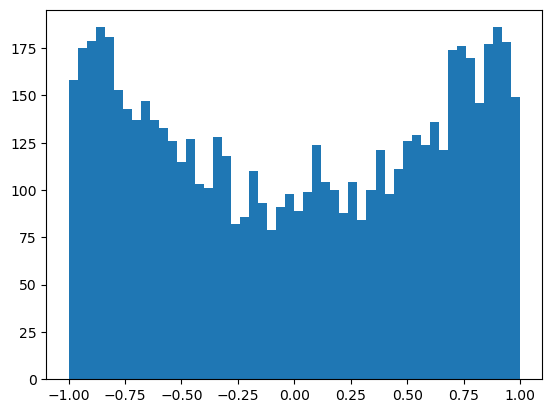

In [73]:
plt.hist(h.view(-1).tolist(),50)

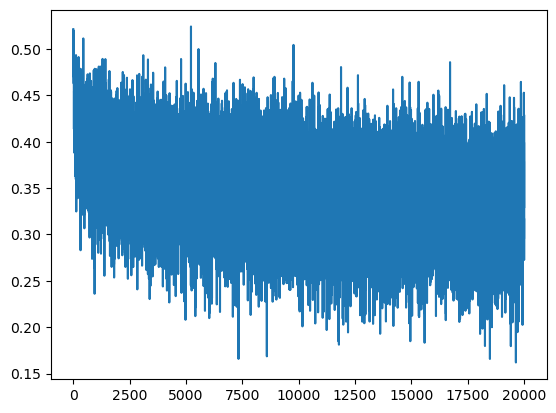

In [54]:
#plt.plot(lri, lossi)
#plt.plot(stepi, lossi)
plt.plot(stepi, lossi)

In [34]:
emb = C[Xdev]
embcat = emb.view(emb.shape[0], -1)
hpre = embcat @ w1 # +b1
hpre = bngain*(hpre - bnmean_running) / bnstd_running + bnbias
h = torch.tanh(hpre)
logits = h @ w2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1906, grad_fn=<NllLossBackward0>)

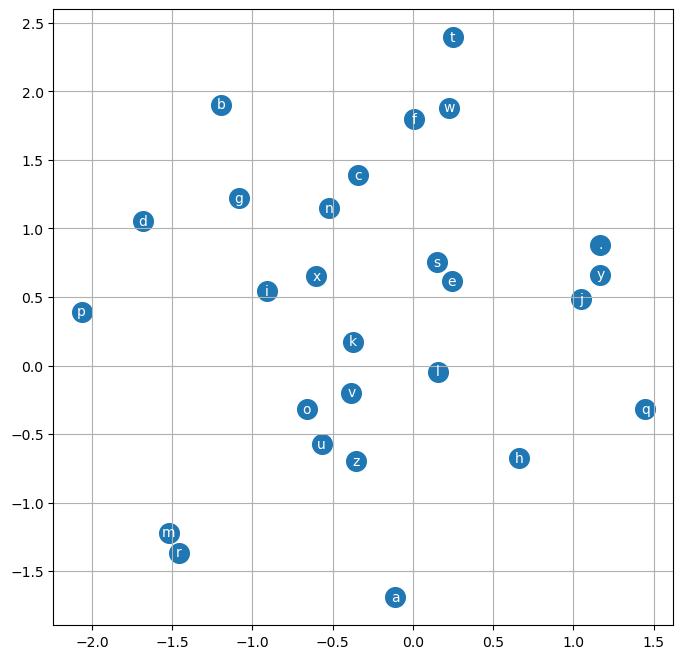

In [56]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("miner")

In [ ]:
# training, validation, testing

In [12]:
# sampling

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
       # print(probs.shape)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''. join(itos[i] for i in out))

kaydahlej.
jaelopkissamaumun.
emper.
aviyanny.
fayla.
vonde.
hataltroya.
alan.
edjoulyn.
andon.
anef.
kamaria.
shalsheejiadnn.
relahelonnee.
abayannahlia.
ladolenn.
oxlrigh.
jeke.
daeraaminey.
rania.
